Reads file `query.csv`

for each image, generate refinements following naming like:
* `000001_refinement_A`
* `000002_refinement_B`
* `000002_refinement_C`

Save file `query_with_description.csv` (still same number of rows as the original, but adding class and description columns) and `query_with_refinements.csv` (expand the number of rows with the new refinements)

In [1]:
import pandas as pd
import os
import logging
from PIL import Image
from typing import List, Tuple
import matplotlib.pyplot as plt
import openai
from openai.error import RateLimitError, InvalidRequestError
import base64
import io
import dotenv
import time

dataset = 'urban-reid-challenge-augmented'
#dataset = 'urban-reid-challenge-reduced'
#dataset = 'urban-reid-challenge'

################ Probably nothing has to be modified from now on ################
logging.root.setLevel(logging.INFO)
dotenv.load_dotenv()

True

In [2]:
class VisualQnA():
    def predict(self, image: Image.Image, question: str) -> str:
        raise NotImplementedError()

class VisualQnAOpenAI(VisualQnA):
    def __init__(self, api_key, api_base, deployment_name, api_type="azure", api_version="2025-01-01-preview"):
        openai.api_key = api_key
        openai.api_base = api_base
        openai.api_type = api_type
        openai.api_version = api_version
        self.deployment_name = deployment_name

    def predict(self, image: Image.Image, question: str) -> str:
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")
        image_b64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

        max_retries = 500
        backoff = 5  # initial backoff in seconds

        for attempt in range(max_retries):
            try:
                response = openai.ChatCompletion.create(
                    deployment_id=self.deployment_name,
                    messages=[
                        {"role": "system", "content": "You are a visual analyzer that provides short and descriptive answers."},
                        {"role": "user", "content": [
                            {"type": "text", "text": question},
                            {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{image_b64}"}}
                        ]}
                    ],
                    temperature=0.2
                )
                return response["choices"][0]["message"]["content"]
            except RateLimitError as e:
                if attempt < max_retries - 1:
                    logging.warning('Rate limited, trying again...')
                    time.sleep(backoff)
                    backoff *= 2  # exponential backoff
                else:
                    raise e

class VisualQnALlava(VisualQnA):
    # Colab example: https://colab.research.google.com/drive/1KsbJjCxndkZLsDDhzdVSZPHdBQdGNV8z?usp=sharing
    # See also: https://huggingface.co/llava-hf/llava-1.5-7b-hf/discussions/52
    pass

In [3]:
def refine(
    split: str,
    has_label: bool,  # if the csv for this split contains a label column that should be preserved
    refinement_templates: List[Tuple[str, str]], # tuples of <type, prompt>
    generate: bool = True,  # Only False for debugging purposes
    
):
    # Classifying and describing each image
    # The total prompt can't have more than 77 clip tokens
    # If it's longer, a hard-clipping will be applied
    prompt = '''You are looking at an image of an urban object, that can be: a crosswalk, a container (big, for house trash of similar), or bin (small, for pedestrian rubbish).
    First, write one single word with which of these 3 objects it is, full stop.
    Then, describe in AT MOST 3 sentences the object, for re-identification purposes. Focus on physical characteristics that make it unique, such as: stickers, graffiti, wear markings, peeling, scratches, dents, nearby signage, etc.
    Be very specific about _where_ is the characteristics (example: on the top-left corner) and _how_ (example: a 20cm light white graffiti of a rose).
    Avoid general descriptions—highlight features that would help distinguish this object from visually similar ones, or any form of blabla that does not help identifying the object, just start describing right away.
    '''
    prompt_safe = '''You are looking at an image of an urban object, that can be: a crosswalk, a container (big, for house trash of similar), or bin (small, for pedestrian rubbish).
    First, write one single word with which of these 3 objects it is, full stop. If you can't identify what it is, just say "crosswalk".
    Then, describe what you are seeing in AT MOST 2 sentences.
    Be brief, don't say anything bad, this is an academic work.
    '''
    model = VisualQnAOpenAI(
        api_key=os.getenv('OPENAI_API_KEY'),
        api_base=os.getenv('OPENAI_API_BASE'),
        deployment_name=os.getenv('OPENAI_DEPLOYMENT_NAME'),
    )

    # Generate
    if generate:
        df = pd.read_csv(f'assets/datasets/{dataset}/{split}.csv')
        if has_label:
            df = df[['cameraID', 'imageName', 'objectID']]
        else:
            df = df[['cameraID', 'imageName']]
        df = df[~df['imageName'].str.contains('_refinement_')]  # In case this is being ran again
        df['class'] = ''
        df['description'] = ''
        
        logging.info(f'Enriching {df.shape[0]} images')
        for index, row in df.iterrows():
            #if index!=178:
            #    continue
            #print('yay')
            #continue
            image_path = os.path.join(f'assets/datasets/{dataset}/image_{split}', row['imageName'])
            image = Image.open(image_path)
            try:
                answer = model.predict(image, prompt)
            except:
                # This error appears when the image triggers the content management policy
                logging.warning(f'Prompt index={index} failed, trying out a safer prompt...')
                try:
                    answer = model.predict(image, prompt_safe)
                except:
                    logging.warning(f'Prompt index={index} violated content management policy AGAIN, fallback to default answer')
                    answer = 'Crosswalk. It is a recently painted pedrestrian crosswalk in a alphat street.'
            df.loc[index, 'class'] = answer.split('. ')[0].strip().lower()
            df.loc[index, 'description'] = '. '.join(answer.split('. ')[1:]).strip()
            logging.info('.')
            #logging.info(f"Image: {row['imageName']}, Answer: {description}")
            #break
        logging.info('Done')
        df.to_csv(f'assets/datasets/{dataset}/{split}_with_description.csv', index=False)

    df = pd.read_csv(f'assets/datasets/{dataset}/{split}_with_description.csv')

    # Debug
    for index, row in df.iterrows():
        image_path = os.path.join(f'assets/datasets/{dataset}/image_{split}', row['imageName'])
        plt.imshow(plt.imread(image_path))
        plt.show()
        print(f'{index}) Class:', row['class'])
        print('Description:', row['description'])
        if index >= 2: # 10:
            break

    # Refinements
    new_rows = []
    for refinement_type, refinement_prompt in refinement_templates:
        for index, row in df.iterrows():
            if has_label:
                # TODO: supporting labels was an afterthought, so this code is ugly as fuck... please improve
                new_rows.append([
                    row['cameraID'],
                    f"{row['imageName'].split('.')[0]}_refinement_{refinement_type}.{row['imageName'].split('.')[-1]}",
                    row['objectID'],
                    row['class'],
                    f"This exact same {row['class']} {refinement_prompt}. {row['description']}",
                ])
            else:
                new_rows.append([
                    row['cameraID'],
                    f"{row['imageName'].split('.')[0]}_refinement_{refinement_type}.{row['imageName'].split('.')[-1]}",
                    row['class'],
                    f"This exact same {row['class']} {refinement_prompt}. {row['description']}",
                ])
    assert len(new_rows) == df.shape[0]*len(refinement_templates)
    if has_label:
        columns = ['cameraID', 'imageName', 'class', 'description', 'objectID']
    else:
        columns = ['cameraID', 'imageName', 'class', 'description']
    df2 = pd.concat([df, pd.DataFrame(new_rows, columns=columns)])
    assert df2.shape[0] == df.shape[0]*(len(refinement_templates)+1)
    assert df2.shape[1] == (5 if has_label else 4)
    logging.info('Saving csv with_refinements')
    df2.to_csv(f'assets/datasets/{dataset}/{split}_with_refinements.csv', index=False)
    logging.info(df2.head(100))
    return df2

INFO:root:--------------------------------------------------
Refining train
INFO:root:Enriching 5 images
INFO:root:.
INFO:root:.
INFO:root:.
INFO:root:.
INFO:root:.
INFO:root:Done


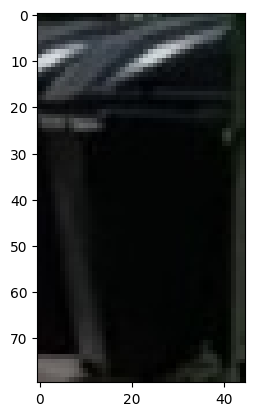

0) Class: bin
Description: The bin is predominantly black with a shiny surface that shows signs of wear, particularly on the bottom-right corner where the paint is chipped, revealing a lighter gray underneath. There is a small, faded sticker on the front, slightly peeling at the edges, indicating it is for recyclable materials. Additionally, the lid has a noticeable dent on the top-left side, which could help in identifying it among similar bins.


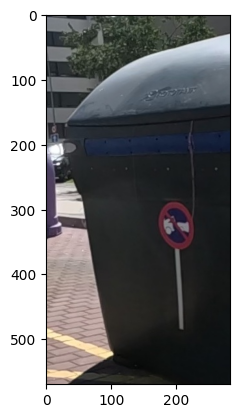

1) Class: bin
Description: The bin has a noticeable dent on the top-right corner, which is about 10cm wide. There is a red circular no littering sign attached to the front, with a white hand symbol that is slightly scratched, making it hard to read. The surface of the bin shows signs of wear, with peeling paint along the bottom edge and a few small scratches scattered across the sides.


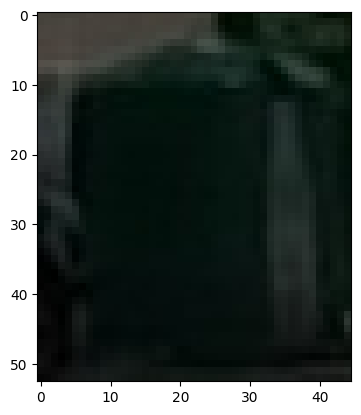

INFO:root:Saving csv with_refinements
INFO:root:  cameraID                imageName  \
0     c001               000001.jpg   
1     c002               000002.jpg   
2     c001               000003.jpg   
3     c001               000004.jpg   
4     c002               000005.jpg   
0     c001  000001_refinement_A.jpg   
1     c002  000002_refinement_A.jpg   
2     c001  000003_refinement_A.jpg   
3     c001  000004_refinement_A.jpg   
4     c002  000005_refinement_A.jpg   

                                            objectID      class  \
0                                                  1        bin   
1                                                  2        bin   
2                                                  3  container   
3                                                  4  crosswalk   
4                                                  5        bin   
0  This exact same bin with a 2 people walking by...          1   
1  This exact same bin with a 2 people walking by... 

2) Class: container
Description: The container is a large, dark green trash bin with noticeable wear markings on the bottom edge, indicating frequent use. There is a distinct 15cm scratch running vertically along the right side, exposing lighter green paint underneath. Additionally, a faded sticker with a recycling symbol is partially peeling off the top-left corner, adding to its unique identification.


In [4]:
#for split, refinement_templates in [
#    ('query', [
#        ('A', 'with a 2 people walking by and partially occluding it'),
#        ('B', 'at sunset with a warm sun shinning on it'),
#        ('C', 'on a rainy day, gray sky, low visibility'),
#    ]),
#    ('test', [
#        ('A', 'with a 2 people walking by and partially occluding it'),
#    ]),
#]:
for split, has_label, refinement_templates in [
    #('query', False, [
    #    ('A', 'with a 2 people walking by and partially occluding it'),
    #    ('B', 'at sunset with a warm sun shinning on it'),
    #    ('C', 'on a rainy day, gray sky, low visibility'),
    #]),
    
    #('test', False, [
    #    ('A', 'with a 2 people walking by and partially occluding it'),
    #]),

    ('train', True, [
        ('A', 'with a 2 people walking by and partially occluding it'),
    ]),

]:
    logging.info('-'*50 + f'\nRefining {split}')
    df2 = refine(split, has_label, refinement_templates)
logging.info('All done, go celebrate')